In [4]:
import pandas as pd

In [5]:
path1 = r"C:\Users\beall\ColabDocs\Bootcamp\Project Recommender\movies.csv"
movies_df = pd.read_csv(path1)

path2 = r"C:\Users\beall\ColabDocs\Bootcamp\Project Recommender\ratings.csv"
ratings_df = pd.read_csv(path2)

In [6]:
pip install scikit-surprise

In [8]:
from surprise import Reader, Dataset, KNNBasic, accuracy
from surprise.model_selection import train_test_split

In [7]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [9]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


# Creating a Recommender based on similarities between users (generating surprise recommendations)

In [11]:
### Creating a new df with the necessary info for a Recommender
data = ratings_df[['userId', 'movieId', 'rating']]

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100836 non-null  int64  
 1   movieId  100836 non-null  int64  
 2   rating   100836 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 2.3 MB


### Surprise dataset

In [14]:
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(data, reader)

### Train & Test

In [16]:
trainset, testset = train_test_split(data, test_size=0.2, random_state=142)

### Model

In [17]:
sim_options = {
    'name': 'cosine',
    'user_based': True
}

knn = KNNBasic(sim_options=sim_options)

In [18]:
knn.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [19]:
predictions = knn.test(testset)

- `uid`: Represents the raw user id
- `iid`: Represents the raw item id
- `r_ui`: Denotes the true rating provided by the user
- `est`: Represents the estimated rating calculated by the model
- `details`: Stores additional information about the prediction, which can be valuable for further analysis. It provides a space to include any relevant details that might enhance the understanding or interpretation of the prediction results

In [20]:
predictions[:5]

[Prediction(uid=380, iid=2085, r_ui=3.0, est=3.5191062895722083, details={'actual_k': 30, 'was_impossible': False}),
 Prediction(uid=367, iid=513, r_ui=4.0, est=2.9999999999999996, details={'actual_k': 2, 'was_impossible': False}),
 Prediction(uid=570, iid=349, r_ui=4.0, est=3.7123899526005637, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=288, iid=2018, r_ui=3.0, est=3.391371971142089, details={'actual_k': 29, 'was_impossible': False}),
 Prediction(uid=446, iid=266, r_ui=2.0, est=3.4014122408648797, details={'actual_k': 40, 'was_impossible': False})]

In [21]:
predictions_df = pd.DataFrame(predictions, columns = ["raw_user_id", "raw_item_id", "actual_user_rating", "estimated_user_rating", "details"])

In [22]:
predictions_df.head()

,raw_user_id,raw_item_id,actual_user_rating,estimated_user_rating,details
0,380,2085,3.0,3.519106,"{'actual_k': 30, 'was_impossible': False}"
1,367,513,4.0,3.000000,"{'actual_k': 2, 'was_impossible': False}"
2,570,349,4.0,3.712390,"{'actual_k': 40, 'was_impossible': False}"
3,288,2018,3.0,3.391372,"{'actual_k': 29, 'was_impossible': False}"
4,446,266,2.0,3.401412,"{'actual_k': 40, 'was_impossible': False}"


### Evaluating the model

#### Metrics

In [31]:
import pandas as pd

# Calculate the metrics
mae_value = accuracy.mae(predictions)
rmse_value = accuracy.rmse(predictions)
fcp_value = accuracy.fcp(predictions)

# Create the DataFrame without specifying the index
ratings_df = pd.DataFrame({
    'MAE': [mae_value],
    'RMSE': [rmse_value],
    'fcp': [fcp_value]
})

# Display the DataFrame
ratings_df


MAE:  0.7462
RMSE: 0.9698
FCP:  0.6685


,MAE,RMSE,fcp
0,0.746228,0.969775,0.668496


#### Plots of the errors

In [43]:
predictions_df["difference"] = predictions_df["actual_user_rating"] - predictions_df["estimated_user_rating"]

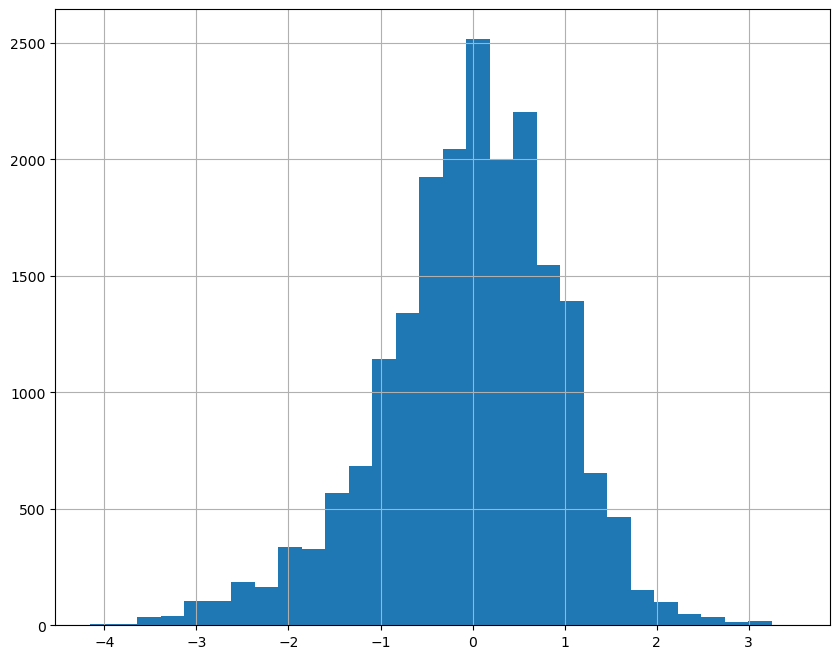

In [44]:
predictions_df["difference"].hist(bins=30,
                                  figsize=(10, 8));

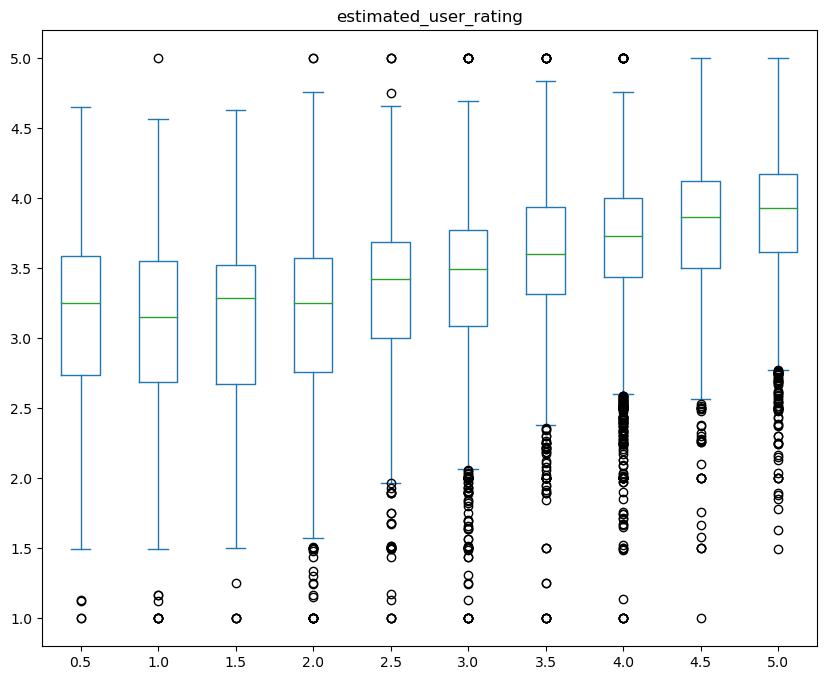

In [45]:
predictions_df.plot(kind='box',
                    column='estimated_user_rating',
                    by='actual_user_rating',
                    figsize=(10, 8));

# Applying the recommender-model

In [32]:
sim_options = {
    'name': 'cosine',
    'user_based': True
}

full_train = data.build_full_trainset()


In [34]:
algo = KNNBasic(sim_options=sim_options)
algo.fit(full_train)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [35]:
testset = full_train.build_anti_testset()

In [36]:
def n_predictions_for_user_2(testset, userId, n):
    filtered_testset = []

    #loop through a big testset
    for row in testset:
        #filter the ones with our user_id
        if row[0] == userId:
            # add the filtered ones to empty list
            filtered_testset.append(row)
    #do predictions on filtered testset
    predictions = algo.test(filtered_testset)
    # turn predictions into a dataframe and return a top 10 predictions based on the predicted ratings - 'est'
    return pd.DataFrame(predictions).nlargest(n,'est')

In [38]:
userId = 380
n=10

top_n_df = n_predictions_for_user_2(testset,userId,n)
top_n_df

,uid,iid,r_ui,est,details
2287,380,176601,3.501557,5.0,"{'actual_k': 1, 'was_impossible': False}"
3721,380,2969,3.501557,5.0,"{'actual_k': 1, 'was_impossible': False}"
4076,380,3096,3.501557,5.0,"{'actual_k': 1, 'was_impossible': False}"
4530,380,99,3.501557,5.0,"{'actual_k': 2, 'was_impossible': False}"
6510,380,96430,3.501557,5.0,"{'actual_k': 1, 'was_impossible': False}"
7515,380,164367,3.501557,5.0,"{'actual_k': 1, 'was_impossible': False}"
122,380,131724,3.501557,5.0,"{'actual_k': 1, 'was_impossible': False}"
140,380,5746,3.501557,5.0,"{'actual_k': 1, 'was_impossible': False}"
144,380,6835,3.501557,5.0,"{'actual_k': 1, 'was_impossible': False}"
268,380,3851,3.501557,5.0,"{'actual_k': 1, 'was_impossible': False}"


In [40]:
filter_df = movies_df[['movieId','title','genres']]

In [42]:
top_n_df[['iid','est']].merge(filter_df,how='left',left_on='iid',right_on='movieId').drop_duplicates()

,iid,est,movieId,title,genres
0,176601,5.0,176601,Black Mirror,(no genres listed)
1,2969,5.0,2969,"Man and a Woman, A (Un homme et une femme) (1966)",Drama|Romance
2,3096,5.0,3096,My Man Godfrey (1957),Comedy
3,99,5.0,99,Heidi Fleiss: Hollywood Madam (1995),Documentary
4,96430,5.0,96430,"Odd Life of Timothy Green, The (2012)",Comedy|Drama|Fantasy
5,164367,5.0,164367,The Girl with All the Gifts (2016),Drama|Horror|Sci-Fi|Thriller
6,131724,5.0,131724,The Jinx: The Life and Deaths of Robert Durst ...,Documentary
7,5746,5.0,5746,Galaxy of Terror (Quest) (1981),Action|Horror|Mystery|Sci-Fi
8,6835,5.0,6835,Alien Contamination (1980),Action|Horror|Sci-Fi
9,3851,5.0,3851,I'm the One That I Want (2000),Comedy
